In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.modeling import models, fitting
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

%matplotlib inline
#%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')
plt.rcParams['axes.grid'] = False

In [2]:
# Function to open the fits file and plot them
def Open_Fits(filepath, plot, cmap='gnuplot2'):
    file_temp = fits.open(filepath)
    file = file_temp[0].data
    file_temp.close()
    if plot == True:
        plt.imshow(file, clim=(0, np.quantile(file, [0.99])), cmap=cmap, origin='lower')
        plt.colorbar(fraction=0.0375, pad=0.02);
    return file

$m_\text{true} = \text{ZP} + m_\text{instrument}$

$-2.5 \log_{10} f_\lambda = \text{ZP} - 2.5 \log_{10} R[e^-/s] \:\:\: \Longrightarrow \:\:\: f_\lambda [erg/s/cm^2/\AA] = 10^{-0.4 \text{ZP}} R[e^-/s]$ 

# Filter Ha

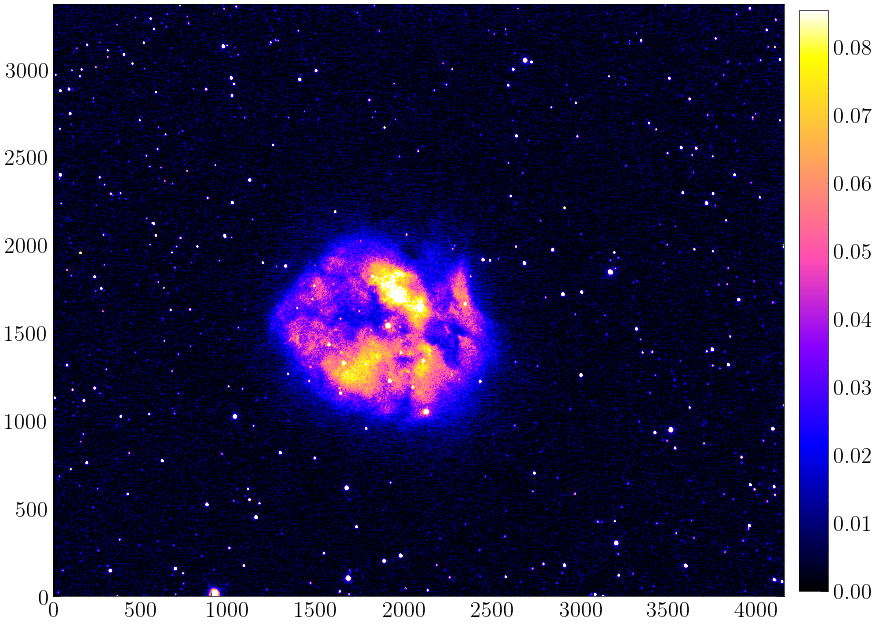

In [3]:
final_Ha = Open_Fits(filepath='Data/final_Ha.fits', plot=True)

In [4]:
final_Ha_radec = fits.open('Data/final_Ha_radec.fits')[1].data
final_Ha_radec

FITS_rec([(328.6532846 , 47.15560772,  921.82434 , 1.74548531e+01, 3.45572052e+01, 0.00260925),
          (328.37017436, 47.26660542, 1907.9147  , 1.53818115e+03, 9.16756153e+00, 0.04750919),
          (328.12018925, 47.38700367, 2686.7764  , 3.04577710e+03, 7.69480991e+00, 0.0024128 ),
          (328.37558545, 47.2012023 , 2125.0745  , 1.04945142e+03, 6.86020613e+00, 0.02323532),
          (328.1420862 , 47.22878445, 3172.8506  , 1.84244763e+03, 6.70983076e+00, 0.00212526),
          (328.16143343, 47.1119084 , 3515.8984  , 9.45524536e+02, 4.97167635e+00, 0.0022378 ),
          (328.39010883, 47.49197238,  970.0183  , 3.12536255e+03, 3.22498703e+00, 0.00243759),
          (328.33571165, 47.44714909, 1404.0621  , 2.93674268e+03, 1.34269893e+00, 0.0023849 ),
          (328.52438474, 47.12269255, 1681.8555  , 1.02863037e+02, 5.45206022e+00, 0.00224209),
          (328.55278954, 47.25886365, 1036.0205  , 1.02124268e+03, 3.96849036e+00, 0.00243831),
          (328.26415876, 47.05925134, 32

In [5]:
print(np.min(final_Ha_radec['ra']), np.max(final_Ha_radec['ra']))
print(np.min(final_Ha_radec['dec']), np.max(final_Ha_radec['dec']))

327.861475729151 328.7958090865958
46.9823001142356 47.5606852155633


In [6]:
GAIA_catalogue = fits.open('Data/GAIA_catalogue_12_145.fit')[1].data
GAIA_catalogue

FITS_rec([(327.86075051624, 47.05895103899, 1974724330898100096, 0.0101, 0.011, 0.4961, 0.0125, 7.281, -4.412, 0.013, -5.792, 0.015, 1.127, 103393.97627, 12.93, 13.151129, 54114.0, 27.568, 13.505274, 70943.0, 21.738, 12.620627, 0.884646, -33.23, 3.52, 0.0, 12.375963, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 6856.1, 3.6398, -0.2169, 1558.9365, 0.9028, 0, 164473278607731403, 1237671939822257612, 0, '', 'URAT1-686501009', 'J215126.58+470332.2', 12648405, 'N2UQ000936', '', '21512658+4703323'),
          (327.86199450915, 47.18136664552, 1974729003822615552, 0.0128, 0.0129, 1.0409, 0.015, 4.848, -3.114, 0.017, -3.716, 0.016, 1.033, 34866.25155, 4.9768, 14.331354, 15744.0, 20.307, 14.845741, 27569.0, 35.801, 13.646839, 1.198902, -32.09, 7.3, 0.0, 13.31239, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 5240.1, 4.2123, 0.0144, 851.5303, 0.5493, 0, 164613278619868314, 1237672026242023511, 0, '', 'URAT1-686501015', 'J215126.86+471053.0', 12648550, 'N2UQ005080', '', '21512688+4710530'),
          (327.86274912969, 47

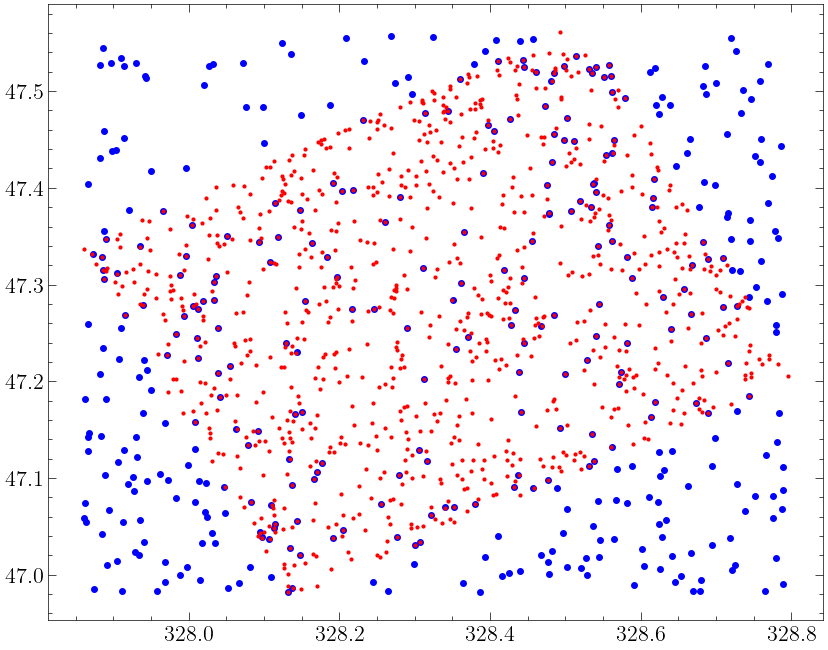

In [7]:
for i in range(len(GAIA_catalogue['RA_ICRS'])):
    plt.plot(GAIA_catalogue['RA_ICRS'][i], GAIA_catalogue['DE_ICRS'][i], c='blue', marker='o', markersize=4)

for i in range(len(final_Ha_radec['ra'])):
    plt.plot(final_Ha_radec['ra'][i], final_Ha_radec['dec'][i], c='red', marker='o', markersize=2)

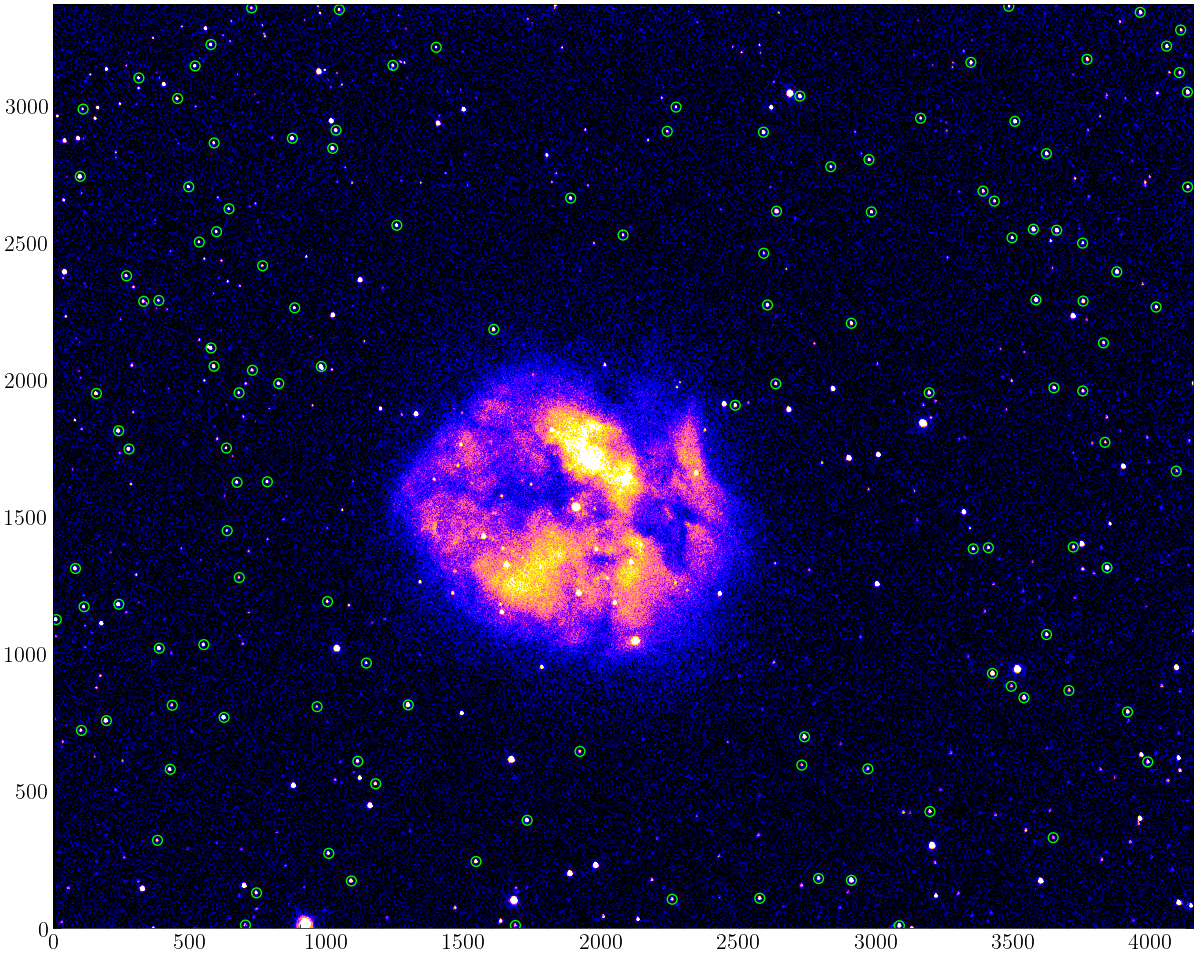

In [8]:
stars_x = []
stars_y = []
stars_mag = []
stars_ra = []   # useless in this code, but can be used to identify the star at https://skyserver.GAIA.org/dr18/VisualTools/navi/
stars_dec = []  # ...

for i in range(len(GAIA_catalogue['RA_ICRS'])):
    if not ((328.25<GAIA_catalogue['RA_ICRS'][i]<328.5) and (47.2<GAIA_catalogue['DE_ICRS'][i]<47.35)):
        # Find the matches between GAIA stars and our stars
        mask_ra = np.isclose(final_Ha_radec['ra'], GAIA_catalogue['RA_ICRS'][i], atol=0, rtol=0.0000015)
        mask_dec = np.isclose(final_Ha_radec['dec'], GAIA_catalogue['DE_ICRS'][i], atol=0, rtol=0.0000015)
        mask_tot = np.logical_and(mask_ra, mask_dec)

        # If there is only one match, append the coordinates (from astrometry.net) and magnitudes (from GAIA catalogue)
        # If there is no match or more than one match, do nothing
        if np.sum(mask_tot) == 1:
            # extra masks to reduce the change of having a second star partially overlapping the first one
            mask_ra = np.isclose(final_Ha_radec['ra'], GAIA_catalogue['RA_ICRS'][i], atol=0, rtol=0.000003)
            mask_dec = np.isclose(final_Ha_radec['dec'], GAIA_catalogue['DE_ICRS'][i], atol=0, rtol=0.000003)
            mask_tot = np.logical_and(mask_ra, mask_dec)

            if np.sum(mask_tot) == 1:
                stars_x.append(final_Ha_radec['x'][mask_tot][0])
                stars_y.append(final_Ha_radec['y'][mask_tot][0])
                stars_mag.append(GAIA_catalogue['Gmag'][i])
                stars_ra.append(GAIA_catalogue['RA_ICRS'][i])
                stars_dec.append(GAIA_catalogue['DE_ICRS'][i])
        
stars_x = np.array(stars_x)
stars_y = np.array(stars_y)
stars_mag = np.array(stars_mag)
stars_ra = np.array(stars_ra)
stars_dec = np.array(stars_dec)
        
plt.figure(figsize=(18,12))
plt.imshow(final_Ha, clim=(0, np.quantile(final_Ha, [0.99])), cmap='gnuplot2', origin='lower')

for i in range(len(stars_x)):
    plt.scatter(stars_x[i], stars_y[i], facecolors='none', edgecolors='lime', s=50)

In [9]:
ra_discard = [328.30728268567, 328.53136583683, 328.68915479341, 328.70924837516]
index_discard = []
for val in ra_discard:
    index_discard.append(np.where(stars_ra==val)[0][0])
    
stars_x = np.delete(stars_x, index_discard)
stars_y = np.delete(stars_y, index_discard)
stars_ra = np.delete(stars_ra, index_discard)
stars_dec = np.delete(stars_dec, index_discard)
stars_mag = np.delete(stars_mag, index_discard)

In [10]:
def Aperture_Photometry(image, stars_x, stars_y, stars_ra, stars_dec, stars_mag, rectangle_side=40, fwhm_factor=3):
    ourfluxes = []

    fig, ax = plt.subplots(figsize=(18,12))
    ax.imshow(image, clim=(0, np.quantile(image, [0.99])), cmap='gnuplot2', origin='lower')

    for i in range(len(stars_x)):
        print(i, stars_ra[i])
        cutout = image[round(stars_y[i]-rectangle_side/2):round(stars_y[i]+rectangle_side/2), round(stars_x[i]-rectangle_side/2):round(stars_x[i]+rectangle_side/2)]

        # 1) Compute the FWHM of the stars to decide the radius of the circular aperture
        # x projection
        x_projection = np.mean(cutout, axis=0)
        x_fit = np.arange(len(x_projection))
        gaussian = models.Gaussian1D(amplitude=np.max(x_projection), mean=len(x_projection)/2, stddev=len(x_projection)/5)
        fit_gaussian = fitting.LevMarLSQFitter()
        fitted_gaussian = fit_gaussian(gaussian, x_fit, x_projection)
        mean_x = fitted_gaussian.mean[0]
        fwhm_x = 2.355*fitted_gaussian.stddev
        
        #fig_temp, axes_temp = plt.subplots(1, 3, figsize=(16,3.5))
        #ax_temp = axes_temp[0]
        #ax_temp.plot(x_projection, label='Data')
        #ax_temp.plot(x_fit, fitted_gaussian(x_fit), label='Fit')
        #ax_temp.axhline(0, c='black', linestyle='--', alpha=0.5, zorder=0)
        #ax_temp.axvline(mean_x, c='black', linestyle='--', alpha=0.7)
        #ax_temp.set_xlabel('y') # In the image, the x-axis of the numpy array becomes the vertical axis!
        
        
        # y projection
        y_projection = np.mean(cutout, axis=1)
        y_fit = np.arange(len(y_projection))
        gaussian = models.Gaussian1D(amplitude=np.max(y_projection), mean=len(y_projection)/2, stddev=len(y_projection)/10)
        fit_gaussian = fitting.LevMarLSQFitter()
        fitted_gaussian = fit_gaussian(gaussian, y_fit, y_projection)
        mean_y = fitted_gaussian.mean[0]
        fwhm_y = 2.355*fitted_gaussian.stddev
        
        #ax_temp = axes_temp[1]
        #ax_temp.plot(y_projection, label='Data')
        #ax_temp.plot(y_fit, fitted_gaussian(y_fit), label='Fit')
        #ax_temp.axhline(0, c='black', linestyle='--', alpha=0.5, zorder=0)
        #ax_temp.axvline(mean_y, c='black', linestyle='--', alpha=0.7)
        #ax_temp.set_xlabel('x') # In the image, the y-axis of the numpy array becomes the horizontal axis!
        
        
        # 2) Redefine the centroid and define the aperture radius
        # the cutout frame, in which mean_x and mean_y are defined, is centered on the left-bottom corner of the rectangle
        aperture_centroid = [round(stars_x[i]-rectangle_side/2)+mean_x, round(stars_y[i]-rectangle_side/2)+mean_y]
        # the aperture radius is a radius, and thus we must divide the FWHM by 2!
        aperture_r = fwhm_factor*np.mean([fwhm_x/2, fwhm_y/2])
        
        
        # 3) Compute the flux of the stars
        aperture = CircularAperture(aperture_centroid, r=aperture_r)
        ourfluxes.append(aperture_photometry(image, aperture)['aperture_sum'][0])
        
        
        # Final plots
        #ax_temp = axes_temp[0]
        #ax_temp.axvline(mean_x-aperture_r, c='red', linestyle='--')
        #ax_temp.axvline(mean_x+aperture_r, c='red', linestyle='--')
        
        #ax_temp = axes_temp[1]
        #ax_temp.axvline(mean_y-aperture_r, c='red', linestyle='--')
        #ax_temp.axvline(mean_y+aperture_r, c='red', linestyle='--')
        
        #ax_temp = axes_temp[2]
        #ax_temp.imshow(cutout, clim=(0, np.quantile(cutout, [0.99])), cmap='gnuplot2', origin='lower')
        #ax_temp.plot(mean_x, mean_y, marker='o', markersize=3, color='lime')
        #circle_plot = plt.Circle([mean_x, mean_y], aperture_r, color='lime', linewidth=1.5, fill=False)
        #ax_temp.add_patch(circle_plot)
        
        circle_plot = plt.Circle(aperture_centroid, aperture_r, color='lime', linewidth=0.8, fill=False)
        ax.add_patch(circle_plot)
        ax.text(aperture_centroid[0]+1.5*aperture_r, aperture_centroid[1]-0.8*aperture_r, f'{i}', fontsize=15, color='lime')
        
        #fig_temp.suptitle(f'Star {i} (ra={stars_ra[i]:.4f}, dec={stars_dec[i]:.4f})  (GAIA_mag={stars_mag[i]:.2f})   (e/s={ourfluxes[i]:.2f})', fontsize=20)
        
    
    return np.array(ourfluxes)

0 327.87263120053
1 327.88575104603
2 327.88635864392
3 327.8874950396
4 327.89084527459
5 327.91621375379
6 327.93614558512
7 327.96582446468
8 327.97097517959
9 327.98325998553
10 327.9885224522
11 327.99444411199
12 327.997124639
13 328.00494196046
14 328.00577815924
15 328.00901572253
16 328.01172042908
17 328.01254090974
18 328.01906201987
19 328.03333529124
20 328.03410242627
21 328.03685416073
22 328.03898570192
23 328.03915467072
24 328.04177162859
25 328.05132368819
26 328.0550483105
27 328.07848894246
28 328.09183574035
29 328.0939510849
30 328.10853852907
31 328.11004910187
32 328.11339266948
33 328.11533909305
34 328.11858787351
35 328.12938048746
36 328.13393827871
37 328.13772878527
38 328.14162363562
39 328.14757530617
40 328.15085210609
41 328.15393572857
42 328.16384078699
43 328.16610587498
44 328.17004520298
45 328.17719280858
46 328.18410374795
47 328.191251589
48 328.1912533412
49 328.19747367327
50 328.20378064368
51 328.21643369207
52 328.24659959761
53 328.25520

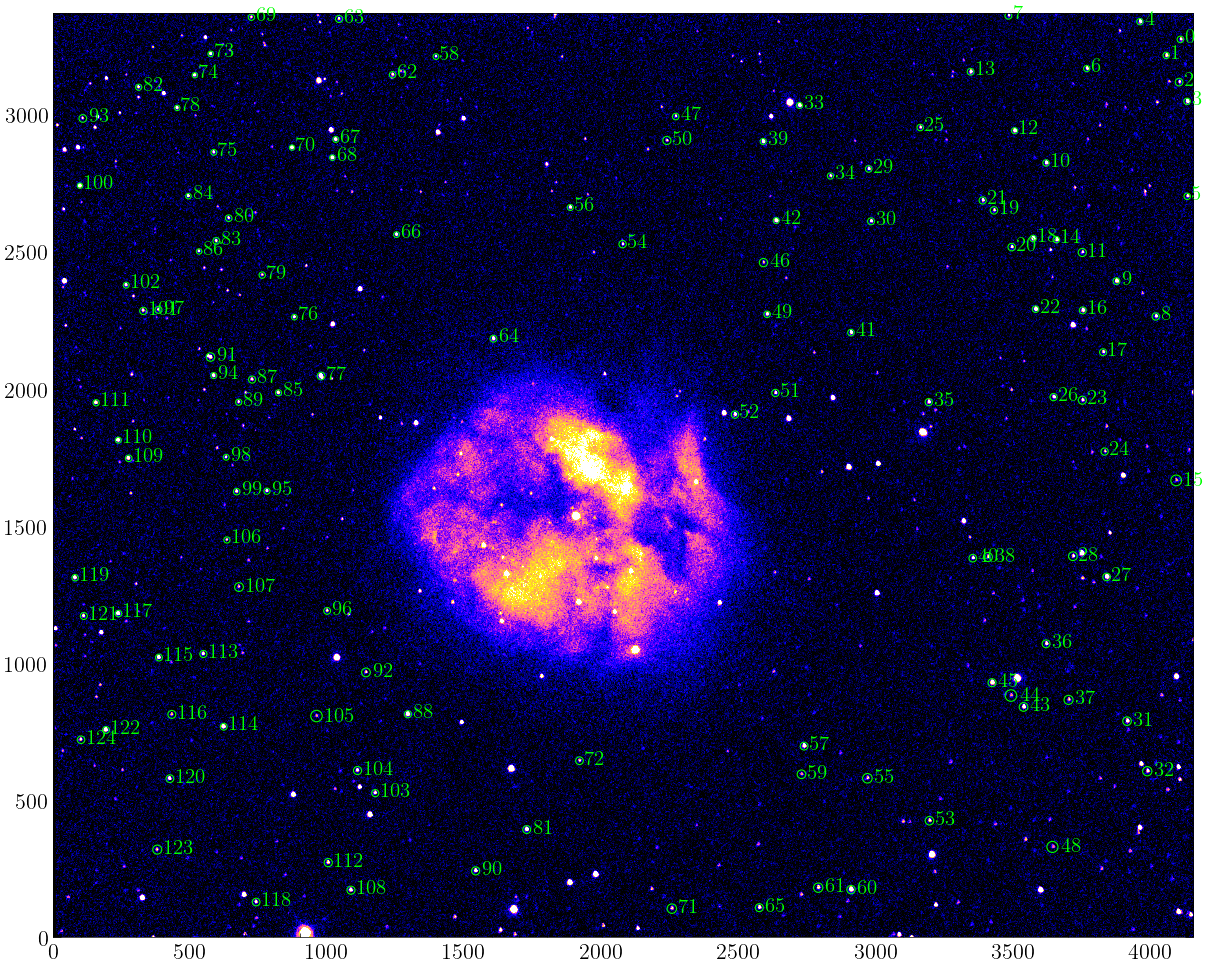

In [11]:
ourfluxes_Ha = Aperture_Photometry(final_Ha, stars_x, stars_y, stars_ra, stars_dec, stars_mag)

# Filter Hb

0 327.87263120053
1 327.88575104603
2 327.88635864392
3 327.8874950396
4 327.89084527459
5 327.91621375379
6 327.93614558512
7 327.96582446468
8 327.97097517959
9 327.98325998553
10 327.9885224522
11 327.99444411199
12 327.997124639
13 328.00494196046
14 328.00577815924
15 328.00901572253
16 328.01172042908
17 328.01254090974
18 328.01906201987
19 328.03333529124
20 328.03410242627
21 328.03685416073
22 328.03898570192
23 328.03915467072
24 328.04177162859
25 328.05132368819
26 328.0550483105
27 328.07848894246
28 328.09183574035
29 328.0939510849
30 328.10853852907
31 328.11004910187
32 328.11339266948
33 328.11533909305
34 328.11858787351
35 328.12938048746
36 328.13393827871
37 328.13772878527
38 328.14162363562
39 328.14757530617
40 328.15085210609
41 328.15393572857
42 328.16384078699
43 328.16610587498
44 328.17004520298
45 328.17719280858
46 328.18410374795
47 328.191251589
48 328.1912533412
49 328.19747367327
50 328.20378064368
51 328.21643369207
52 328.24659959761
53 328.25520

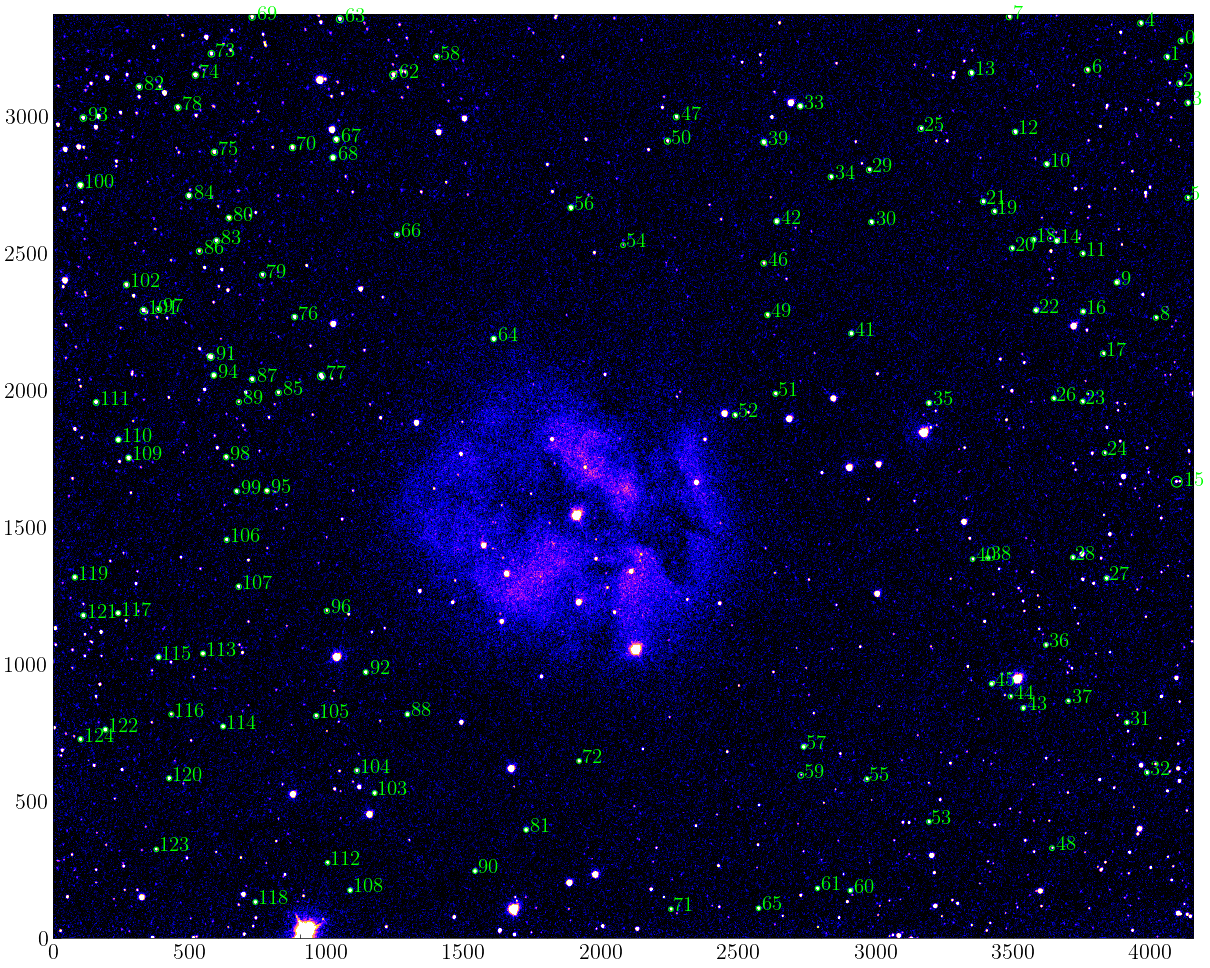

In [12]:
final_Hb = Open_Fits(filepath='Data/final_Hb.fits', plot=False)

ourfluxes_Hb = Aperture_Photometry(final_Hb, stars_x, stars_y, stars_ra, stars_dec, stars_mag)

# Filter g

0 327.87263120053
1 327.88575104603
2 327.88635864392
3 327.8874950396
4 327.89084527459
5 327.91621375379
6 327.93614558512
7 327.96582446468
8 327.97097517959
9 327.98325998553
10 327.9885224522
11 327.99444411199
12 327.997124639
13 328.00494196046
14 328.00577815924
15 328.00901572253
16 328.01172042908
17 328.01254090974
18 328.01906201987
19 328.03333529124
20 328.03410242627
21 328.03685416073
22 328.03898570192
23 328.03915467072
24 328.04177162859
25 328.05132368819
26 328.0550483105
27 328.07848894246
28 328.09183574035
29 328.0939510849
30 328.10853852907
31 328.11004910187
32 328.11339266948
33 328.11533909305
34 328.11858787351
35 328.12938048746
36 328.13393827871
37 328.13772878527
38 328.14162363562
39 328.14757530617
40 328.15085210609
41 328.15393572857
42 328.16384078699
43 328.16610587498
44 328.17004520298
45 328.17719280858
46 328.18410374795
47 328.191251589
48 328.1912533412
49 328.19747367327
50 328.20378064368
51 328.21643369207
52 328.24659959761
53 328.25520

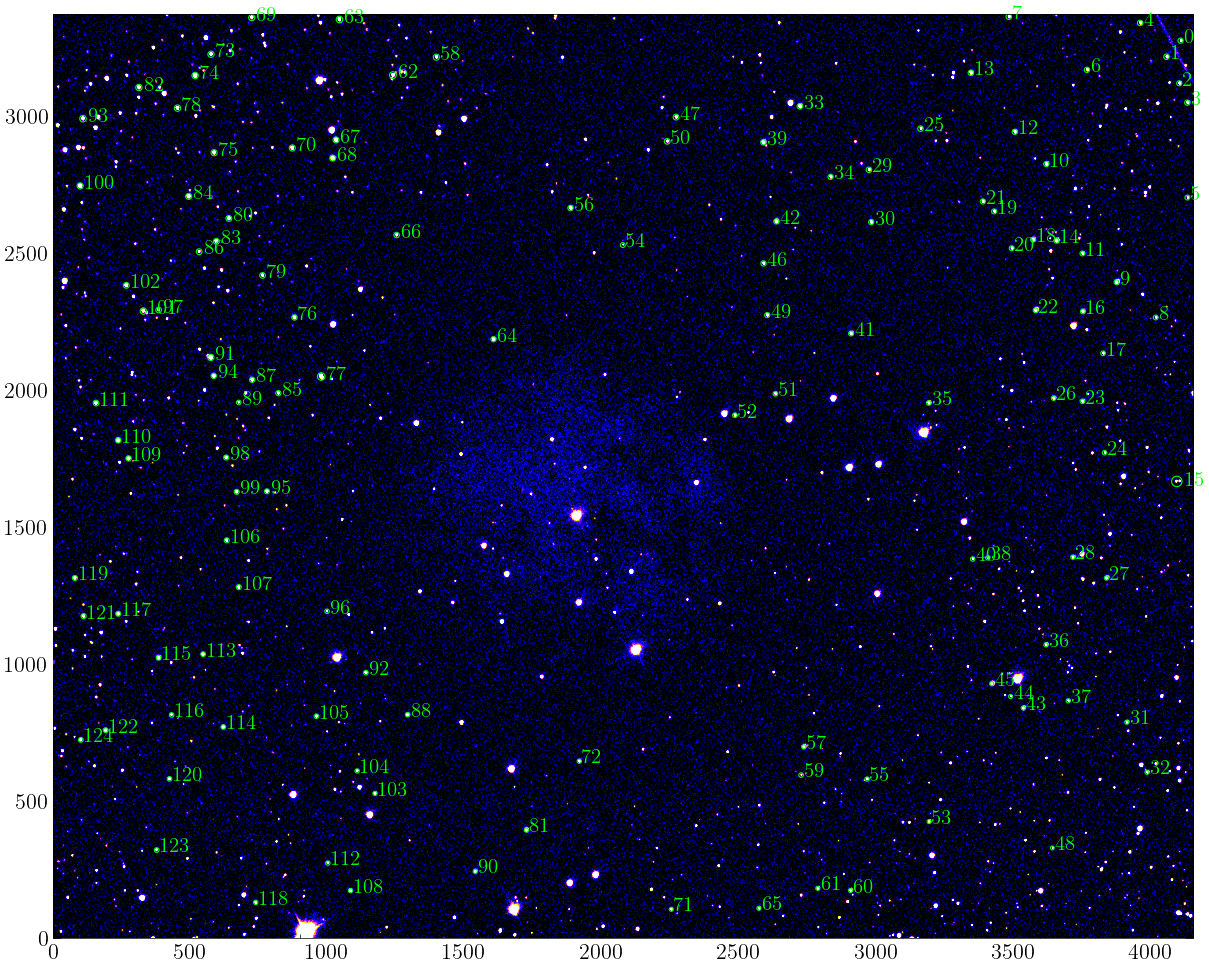

In [13]:
final_g = Open_Fits(filepath='Data/final_g.fits', plot=False)

ourfluxes_g = Aperture_Photometry(final_g, stars_x, stars_y, stars_ra, stars_dec, stars_mag)

# Filter r

0 327.87263120053
1 327.88575104603
2 327.88635864392
3 327.8874950396
4 327.89084527459
5 327.91621375379
6 327.93614558512
7 327.96582446468
8 327.97097517959
9 327.98325998553
10 327.9885224522
11 327.99444411199
12 327.997124639
13 328.00494196046
14 328.00577815924
15 328.00901572253
16 328.01172042908
17 328.01254090974
18 328.01906201987
19 328.03333529124
20 328.03410242627
21 328.03685416073
22 328.03898570192
23 328.03915467072
24 328.04177162859
25 328.05132368819
26 328.0550483105
27 328.07848894246
28 328.09183574035
29 328.0939510849
30 328.10853852907
31 328.11004910187
32 328.11339266948
33 328.11533909305
34 328.11858787351
35 328.12938048746
36 328.13393827871
37 328.13772878527
38 328.14162363562
39 328.14757530617
40 328.15085210609
41 328.15393572857
42 328.16384078699
43 328.16610587498
44 328.17004520298
45 328.17719280858
46 328.18410374795
47 328.191251589
48 328.1912533412
49 328.19747367327
50 328.20378064368
51 328.21643369207
52 328.24659959761
53 328.25520

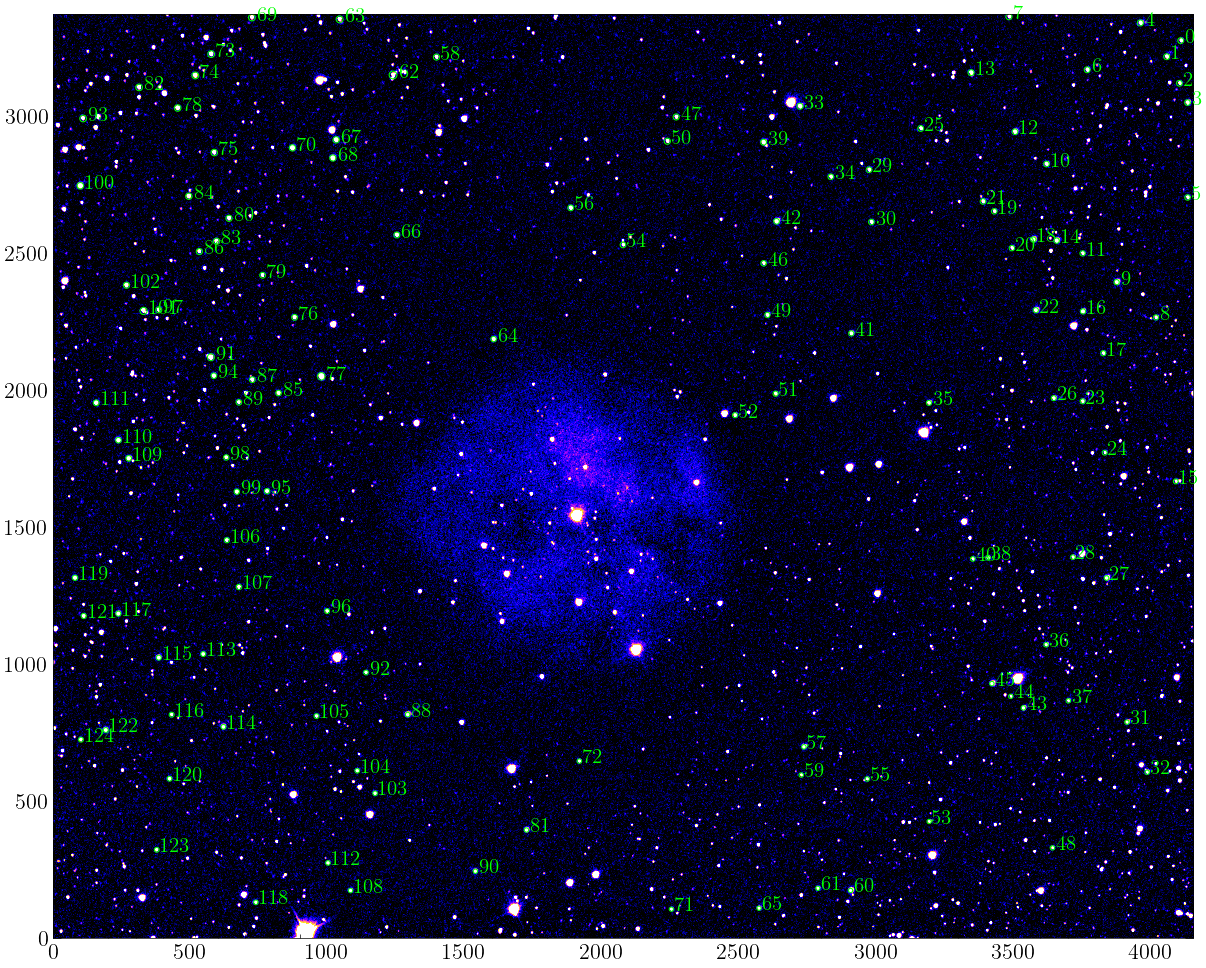

In [14]:
final_r = Open_Fits(filepath='Data/final_r.fits', plot=False)

ourfluxes_r = Aperture_Photometry(final_r, stars_x, stars_y, stars_ra, stars_dec, stars_mag)

# Filter i

0 327.87263120053
1 327.88575104603
2 327.88635864392
3 327.8874950396
4 327.89084527459
5 327.91621375379
6 327.93614558512
7 327.96582446468
8 327.97097517959
9 327.98325998553
10 327.9885224522
11 327.99444411199
12 327.997124639
13 328.00494196046
14 328.00577815924
15 328.00901572253
16 328.01172042908
17 328.01254090974
18 328.01906201987
19 328.03333529124
20 328.03410242627
21 328.03685416073
22 328.03898570192
23 328.03915467072
24 328.04177162859
25 328.05132368819
26 328.0550483105
27 328.07848894246
28 328.09183574035
29 328.0939510849
30 328.10853852907
31 328.11004910187
32 328.11339266948
33 328.11533909305
34 328.11858787351
35 328.12938048746
36 328.13393827871
37 328.13772878527
38 328.14162363562
39 328.14757530617
40 328.15085210609
41 328.15393572857
42 328.16384078699
43 328.16610587498
44 328.17004520298
45 328.17719280858
46 328.18410374795
47 328.191251589
48 328.1912533412
49 328.19747367327
50 328.20378064368
51 328.21643369207
52 328.24659959761
53 328.25520

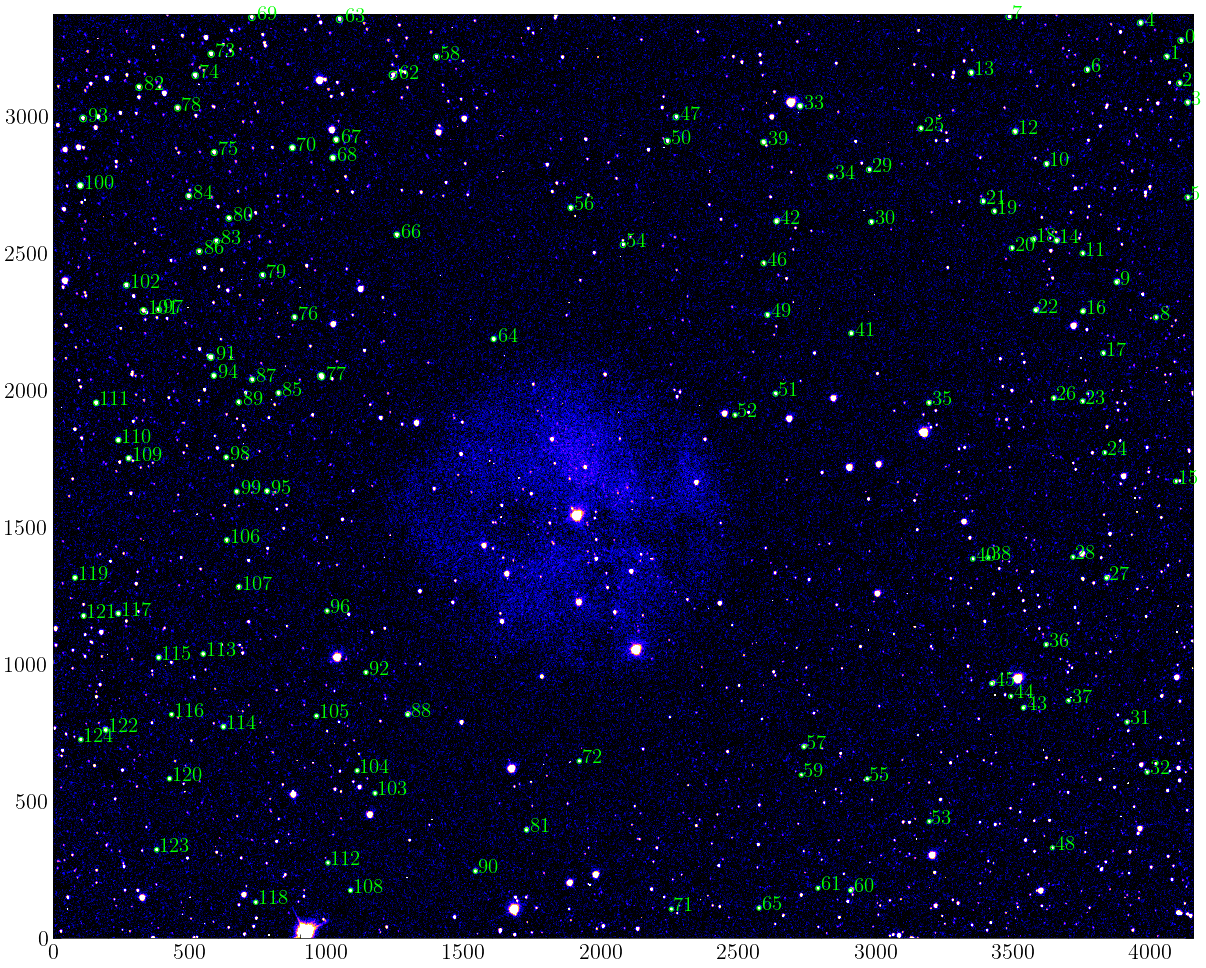

In [15]:
final_i = Open_Fits(filepath='Data/final_i.fits', plot=False)

ourfluxes_i = Aperture_Photometry(final_i, stars_x, stars_y, stars_ra, stars_dec, stars_mag)

# Science?

$ \mathrm{flux}_{\mathrm{H}\alpha}/\mathrm{flux}_{\mathrm{H}\beta} \approx 2.86^{+0.18}_{-0.11} $

$D = \frac{f_{\mathrm{H}\alpha}}{f_{\mathrm{H}\beta}} - 2.9 = (R_\alpha / R_\beta) 10^{-0.4(ZP_{\alpha} - ZP_{\beta})} - 2.9$  Minimo X>0.2 perché abbia qualche senso

Area nebulosa divisa in 3000 sezioni da 180 pixel, per noi sarebbero circa 450 pixel per sezione (Binning 0.0167 × 0.0167 × 0.0167 dex^3 ?)

https://www.aanda.org/articles/aa/full_html/2023/02/aa45072-22/aa45072-22.html